In [7]:
import pandas as pd
import numpy as np
from cassandra.cluster import Cluster

def get_wyckoff_data(symbol):
    cluster = Cluster(['127.0.0.1'], port=9042)
    session = cluster.connect('data_stock')
    # ดึงข้อมูล OHLCV
    query = f"SELECT time, open, high, low, close, volume FROM candlestick_data WHERE symbol = '{symbol}' ALLOW FILTERING"
    df = pd.DataFrame(list(session.execute(query)))
    df['time'] = pd.to_datetime(df['time'])
    df.sort_values('time', inplace=True)
    cluster.shutdown()
    return df.reset_index(drop=True)

df = get_wyckoff_data('TRUE')

In [8]:
def create_labels(df):
    # ใช้ Logic เดิมของคุณสร้างเป้าหมาย (Target)
    long_ma = df['close'].rolling(50).mean()
    vol_ma = df['volume'].rolling(30).mean()
    
    target = []
    for i in range(len(df)):
        if df['close'].iloc[i] < long_ma.fillna(0).iloc[i] and df['volume'].iloc[i] > vol_ma.fillna(0).iloc[i]:
            target.append(1) # Accumulation
        elif df['close'].iloc[i] > long_ma.fillna(0).iloc[i] and df['volume'].iloc[i] > vol_ma.fillna(0).iloc[i]:
            target.append(2) # Distribution
        else:
            target.append(0)
    return np.array(target)

labels = create_labels(df)

In [9]:
from sklearn.preprocessing import MinMaxScaler

# เลือก Feature ที่สัมพันธ์กับพฤติกรรม Wyckoff
df['returns'] = df['close'].pct_change()
df['spread'] = (df['high'] - df['low']) / df['close']
df.fillna(0, inplace=True)

features = ['close', 'volume', 'returns', 'spread']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(df[features])

In [10]:
def prepare_sequences(features, labels, window_size=30):
    X, y = [], []
    for i in range(window_size, len(features)):
        # ดึงข้อมูลย้อนหลัง 30 วันมาเป็น X
        X.append(features[i-window_size:i])
        # ดึง Label ของวันที่ 31 มาเป็นคำตอบ (y)
        y.append(labels[i])
    return np.array(X), np.array(y)

WINDOW_SIZE = 30
X, y = prepare_sequences(scaled_features, labels, WINDOW_SIZE)
# X shape: (Samples, 30, 4) -> (จำนวนชุด, ย้อนหลัง 30 วัน, 4 ฟีเจอร์)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

model = Sequential([
    # LSTM Layer 1: รับข้อมูล 30 วันย้อนหลัง
    LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    Dropout(0.2),
    
    # LSTM Layer 2: สกัดฟีเจอร์เชิงลึก
    LSTM(32),
    BatchNormalization(),
    
    # Output Layer: พยากรณ์ 3 คลาส (Normal, Accum, Dist)
    Dense(16, activation='relu'),
    Dense(3, activation='softmax') # Softmax สำหรับ Multi-class
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/Users/hilmanyusoh/Desktop/stock_pattern/venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
# ใน Time-series ห้ามสุ่มข้อมูล ต้องแบ่งตามลำดับเวลา
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# เริ่มสอน AI
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# ทำนายผล
y_pred = np.argmax(model.predict(X_test), axis=1)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.4041 - loss: 1.0790 - val_accuracy: 0.5970 - val_loss: 1.0475
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5959 - loss: 0.9519 - val_accuracy: 0.5970 - val_loss: 1.0312
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5865 - loss: 0.8934 - val_accuracy: 0.5970 - val_loss: 1.0169
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5902 - loss: 0.8641 - val_accuracy: 0.5970 - val_loss: 1.0303
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6015 - loss: 0.8295 - val_accuracy: 0.5970 - val_loss: 1.0107
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6203 - loss: 0.8091 - val_accuracy: 0.5970 - val_loss: 0.9933
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5996 - loss: 0.8092 - val_accuracy: 0.5970 - val_loss: 0.9972
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6222 - loss: 0.7965 - val_accuracy: 0.5970 - v

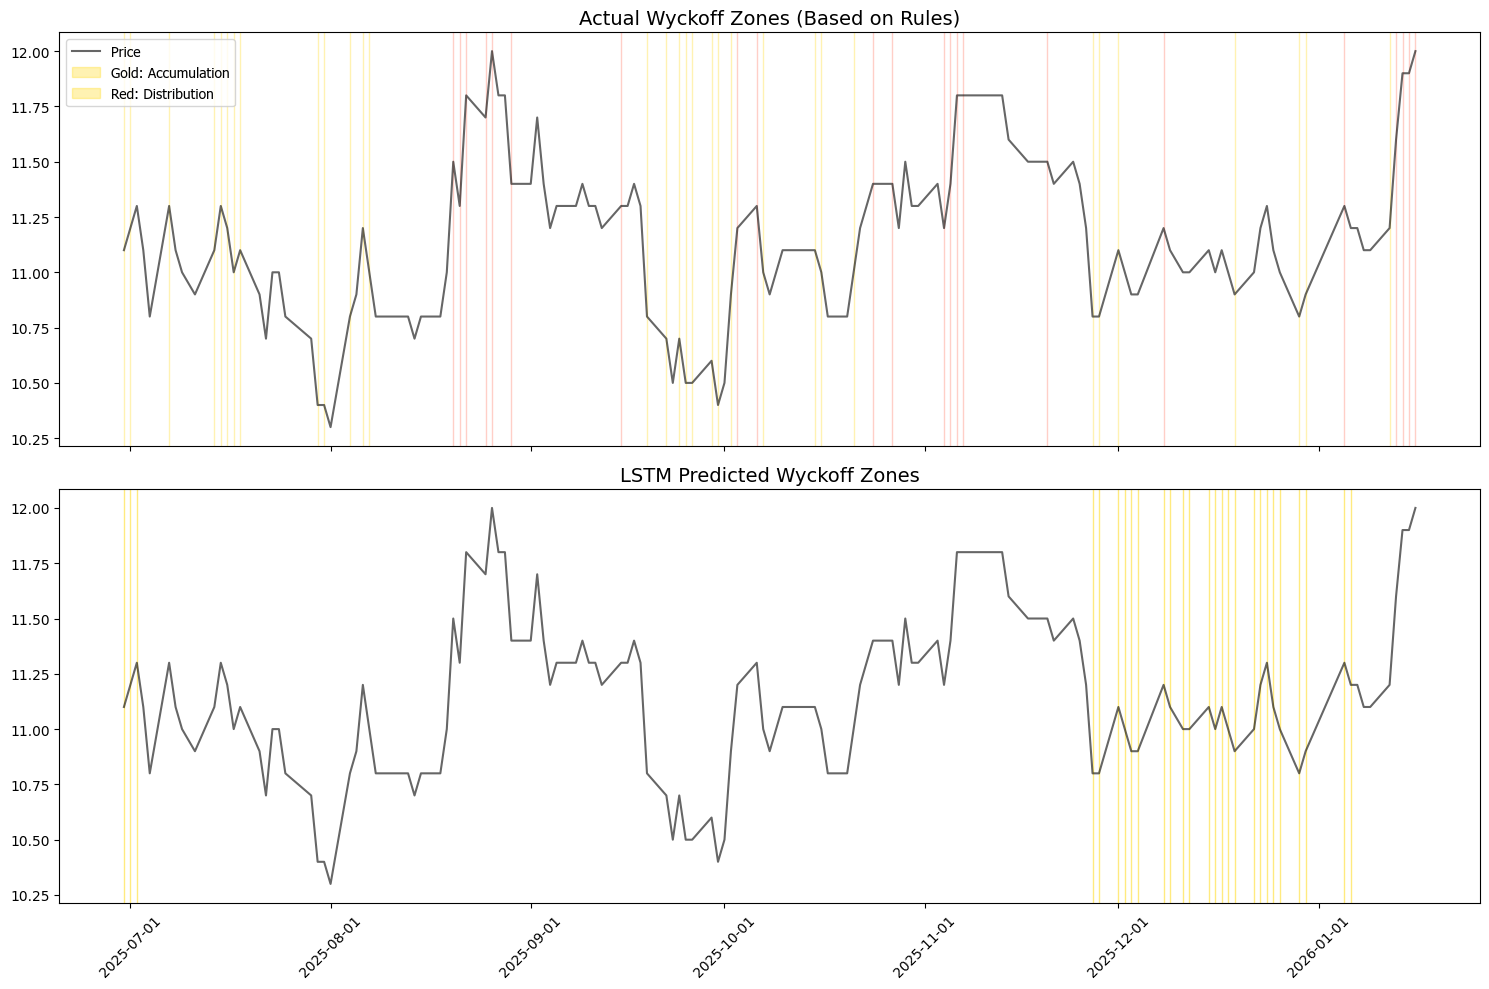

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_lstm_results(df, y_test, y_pred, window_size):
    # ตัดข้อมูล df ให้เหลือเฉพาะส่วนที่เป็น Test Set และตรงกับช่วงที่ทำ Prediction
    test_df = df.iloc[-len(y_test):].copy()
    test_df['actual'] = y_test
    test_df['predicted'] = y_pred
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    plt.rcParams['font.family'] = 'Tahoma'

    # --- กราฟที่ 1: แสดงโซนจริง (Actual Zones) ---
    ax1.plot(test_df['time'], test_df['close'], color='black', alpha=0.6, label='Price')
    
    # วาดแถบสีตาม Label จริง
    for i in range(len(test_df)):
        if test_df['actual'].iloc[i] == 1: # Accumulation
            ax1.axvspan(test_df['time'].iloc[i], test_df['time'].iloc[i], color='gold', alpha=0.3)
        elif test_df['actual'].iloc[i] == 2: # Distribution
            ax1.axvspan(test_df['time'].iloc[i], test_df['time'].iloc[i], color='tomato', alpha=0.3)
            
    ax1.set_title("Actual Wyckoff Zones (Based on Rules)", fontsize=14)
    ax1.legend(['Price', 'Gold: Accumulation', 'Red: Distribution'], loc='upper left')

    # --- กราฟที่ 2: แสดงโซนที่ LSTM ทำนาย (LSTM Predicted Zones) ---
    ax2.plot(test_df['time'], test_df['close'], color='black', alpha=0.6)
    
    # วาดแถบสีตามที่ AI ทำนาย
    for i in range(len(test_df)):
        if test_df['predicted'].iloc[i] == 1:
            ax2.axvspan(test_df['time'].iloc[i], test_df['time'].iloc[i], color='gold', alpha=0.5)
        elif test_df['predicted'].iloc[i] == 2:
            ax2.axvspan(test_df['time'].iloc[i], test_df['time'].iloc[i], color='tomato', alpha=0.5)
            
    ax2.set_title("LSTM Predicted Wyckoff Zones", fontsize=14)
    
    # ฟอร์แมตวันที่
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# เรียกใช้ฟังก์ชัน
plot_lstm_results(df, y_test, y_pred, WINDOW_SIZE)

Classification Report:
              precision    recall  f1-score   support

      Normal       0.59      0.79      0.67        80
Accumulation       0.30      0.25      0.27        32
Distribution       0.00      0.00      0.00        22

    accuracy                           0.53       134
   macro avg       0.30      0.35      0.31       134
weighted avg       0.42      0.53      0.47       134



/Users/hilmanyusoh/Desktop/stock_pattern/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/hilmanyusoh/Desktop/stock_pattern/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/hilmanyusoh/Desktop/stock_pattern/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

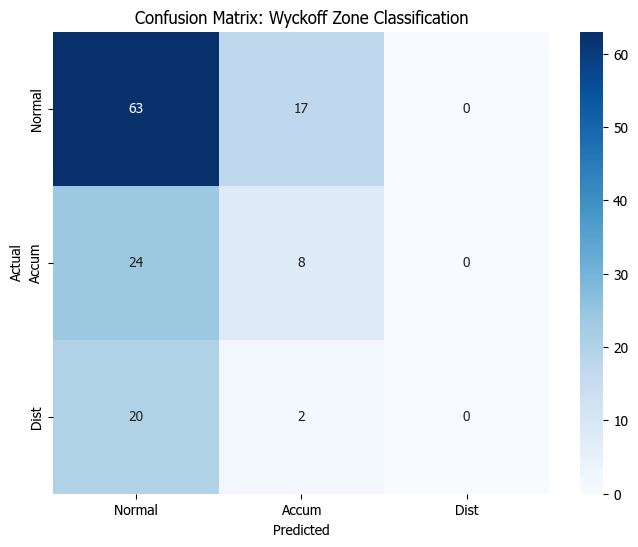

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1. แสดงรายงาน Accuracy, Precision, Recall
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Accumulation', 'Distribution']))

# 2. วาด Confusion Matrix เพื่อดูว่า AI สับสนโซนไหนบ่อยสุด
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Accum', 'Dist'], 
            yticklabels=['Normal', 'Accum', 'Dist'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Wyckoff Zone Classification')
plt.show()